# Automatic E-mail Categorization

The focus of this project is to classify e-mails into folders using the content of each e-mail.  How strong is the correlation between the words in an e-mail and the folder that a user places the e-mail?  To answer these questions, the processed data will be trained, tested and evaluated using several machine learning models.  

Undoubtedly, categorizing e-mails based on the content alone can pose so many challenges.  In reality, there is a constant stream of new information being passed through e-mails each day and much of what we learned through previous e-mails may not contain this new information.
Also, the content of e-mail threads can branch off onto new topics.  Users could also create mostly unused folders.  The problems go on, but you get the idea of the scope of this problem.  

Nonetheless, I found this to be an interesting angle to tackle the Enron Corpus, the largest public domain database in the world containing real-world email messages.  The version used contains over 500,000 emails from about 150 users, mostly senior management at Enron. You can visit [here](https://en.wikipedia.org/wiki/Enron_scandal) to learn more about the Enron scandal.  You can get a copy of the dataset [here](https://www.cs.cmu.edu/~./enron/).  

Benchmark results and for this project can be found [here](http://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1217&context=cs_faculty_pubs).  Bekkerman et al. (Ron Bekkerman, Andrew McCallum and Gary Huang). *Automatic Categorization of Email into Folders: Benchmark Experiments on Enron and SRI Corpora*

## 1. Exploring the Enron Emails Dataset

In [2]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)
import numpy as np
from IPython.display import display

filepath = "data/emails.csv"
# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath) 
print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
# Print column names
print(emails.columns)
# Store column headers 
headers = [header for header in emails.columns]
# Print the first 5 rows of the dataset
print(display(emails.head()))

Successfully loaded 517401 rows and 2 columns!
Index([u'file', u'message'], dtype='object')


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


None


Numpy and pandas were imported, then the csv file containing the e-mails was read into a dataframe called **`emails`**.  The reading may take a while due to the size of the file.  Next, the shape of the dataset, column names and a sample of five rows within the dataset were printed.  There are 517,401 rows and 2 columns.  

**`file`** - contains the original directory and filename of each email. The root level of this path is the employee (surname first followed by first name initial) to whom the emails belong. 

**`message`** - contains the email text

### A sample e-mail

Here is a sample of the standard e-mail found in the data.  It contains a list of headers and a message body.  Note that there is a header label called "Mime-Version", which signifies that the e-mails in this dataset are MIME formatted.  MIME stands for Multipurpose Internet Mail Extensions and virtually all human-written email is transmitted in MIME format.  Python has a built in [MIME handling package](https://docs.python.org/2/library/email.html) and this is what will be used to dissect the data needed out of each e-mail.

In [2]:
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


### Features and Label

From each e-mail, we can extract headers such as `To`, `Subject`, `From`, `X-cc`,`X-bcc` and the message body to use as features.  The `X-Folder` header will be our label.  It  contains the path to each folder.  

Essentially, we are taking several features of the e-mail to classify the folder in which the e-mail was stored.  Note though that all of the headers are in strings and we will need to be able to process these headers for the computer to interpret them.  The [Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model will be used to take text documents, such as our features and output a numerical representation as a feature vector.  

The label, `X-folder` contains several folders and subfolders.  To better visualize all the end nodes of these folders, it would make sense to extract them from the entire filepath and append it to our existing `emails` dataframe.  

## 2. Data Cleaning

Here are the list of things that needs to be performed on the data:
* Extract relevant features from e-mail headers 
* Add new columns in the `emails` dataframe 
* Check for missing values
* Remove unwanted characters 

### Extract headers

In [3]:
import email

def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary

def get_headers(df, header_names):
    headers = {}
    messages = df["message"]
    for message in messages:
        e = email.message_from_string(message)
        header = e.items()
        for item in header:
            if item[0] in header_names:
                key = item[0]
                value = item[1]
                insert_value(headers, key, value)
    return headers
header_names = ["Date", "Subject", "X-Folder", "X-From", "X-To", "X-bcc", "X-cc"]    
headers = get_headers(emails, header_names)

### Explore folders

Here we print a sample of randomly selected folders from a newly created `folders` dataframe.  Take a look at the end node, or the last folder in each row and you will notice that there are more than two folder options in use.  The Enron employees stored their e-mails across several folders and as such, this looks like a [**multiclass classification**](https://en.wikipedia.org/wiki/Multiclass_classification) problem.  For this project, the one-versus-all method will be used to tackle this problem.  In a one-versus-all method, we are essentially doing a binary classification for n number of classes.  Therefore n number of models will be trained for each class based on the number of folders used by each employee. 

In [120]:
print(display(pd.DataFrame(headers["X-Folder"], columns = ["Folders"]).sample(n = 7)))

,Folders
18510,"\Edward_Baughman_Jan2002\Baughman Jr., Don\Deleted Items"
13946,\Eric_Bass_Dec2000\Notes Folders\Discussion threads
511544,"\ExMerge - Williams III, Bill\Schedule Crawler"
132952,"\ExMerge - Germany, Chris\Sent Items"
392455,\Richard_Sanders_Oct2001\Notes Folders\All documents
136552,\Darron_Giron_Jun2001\Notes Folders\'sent mail
417939,\Sara_Shackleton_Dec2000_June2001_1\Notes Folders\All documents


None


### Add features and label to dataset

In [168]:
def add_columns(df, column, labels):
    new_data = {}
    for item in df[column]: 
        # Split string into tokens
        tokens = item.split('/')
            # Get employee name (eg."allen-p")
        for i in range(0, len(labels)):
            value = tokens[i]
            key = labels[i]
            new_data = insert_value(new_data, key, value)
            # Get folder (eg."_sent_mail")         
    for key, value in new_data.items():
        df[key] = pd.Series(value)
    return df
emails = add_columns(df = emails, column = "file", labels = ["employee"])

In [ ]:
count = emails["employee"].value_counts()
print count[:20]

####  Remove regular expressions and lower case message body

Before we can create the bag-of-words model, the message body of each e-mail will need to be extracted and cleaned of special characters, which includes punctuation marks and nonword characters.  I will use Python's regular expression ([regex](https://docs.python.org/2/library/re.html)) libary to remove these characters. 

In [9]:
import re

def remove_reg_expressions(data):
    cleaned_messages = []
    for item in data:
        text = re.sub(r'[\W\d]', " ", item)
        cleaned_messages.append(text)
    return cleaned_messages

### Here is a summary of the new `emails` dataset containing all the new columns.  

In [171]:
print(emails.shape)
print(display(emails.head()))

(517401, 4)


,file,message,employee,folder
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,allen-p,_sent_mail
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,allen-p,_sent_mail
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,allen-p,_sent_mail
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,allen-p,_sent_mail
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,allen-p,_sent_mail


None


### Missing Values

The `emails` dataframe was checked for missing values.  In this case, there were no missing values.

In [4]:
# Check for null values
null_values = emails.isnull().values.any()
if null_values == False: 
    print "No NaN values"
else:
    print null_values

No NaN values


### Remove Non-Topical Folders that are end nodes

Non-topical folders refer to folders that hold e-mails regardless of content (inbox, sent, trash, drafts are just a few).  These will be removed because it is pretty hard to accurately train a classifier using them. Below, you will find a list of all the end node folders and the number of e-mails stored in each.  Notice that a large portion of e-mails are stored in the automatically created folders of an e-mail application, such as:
* all_documents
* discussion_threads
* sent
* deleted_items
* inbox
* sent_items
* notes_inbox
* _sent_mail
* calendar

Note also that there are a lot of e-mails that were stored in a bunch of user created folders.  These will be more relevant for our classification problem.  

In [5]:
folder_count = emails["folder"].value_counts()
print(folder_count[:20])

all_documents          128103
discussion_threads      58609
sent                    57653
deleted_items           51356
inbox                   44859
sent_items              37921
notes_inbox             36665
_sent_mail              30109
calendar                 6133
archiving                4477
_americas                4021
personal                 2577
attachments              2026
meetings                 1872
c                        1656
schedule_crawler         1398
chris_stokley            1252
logistics                1192
archive                  1179
tw_commercial_group      1159
Name: folder, dtype: int64


In [3]:
# Folders we can filter out
non_topical_folders = ["_sent_mail", "calendar", "all_documents", "discussion_threads",
                       "sent", "deleted_items", "inbox", "sent_items", "notes_inbox"]

# A new dataframe without non-topical folders
emails = emails.loc[~emails['folder'].isin(non_topical_folders)]
print(emails.head())
print("The filtered dataframe now contains {} rows.  This is a much reduced dataframe, but still a lot of data!").format(emails.shape[0])

                     file                                            message  \
1230  allen-p/contacts/1.  Message-ID: <15816310.1075855374294.JavaMail.e...   
1231  allen-p/contacts/2.  Message-ID: <6521706.1075855374316.JavaMail.ev...   
3026     allen-p/straw/1.  Message-ID: <12644875.1075855692817.JavaMail.e...   
3027     allen-p/straw/2.  Message-ID: <22208447.1075855692838.JavaMail.e...   
3028     allen-p/straw/3.  Message-ID: <31438311.1075855692860.JavaMail.e...   

     employee    folder  
1230  allen-p  contacts  
1231  allen-p  contacts  
3026  allen-p     straw  
3027  allen-p     straw  
3028  allen-p     straw  
The filtered dataframe now contains 65993 rows.  This is a much reduced dataframe, but still a lot of data!


### Remove folders that contain just one e-mail

We also remove folders that contain one e-mail because such folders would not be significant for training our models later on.  Also, we can also infer that such folders were unused.

In [4]:
email_count = emails["folder"].value_counts()
email_count = dict(email_count)
small_folders = [key for key, val in email_count.items() if val < 2]
emails = emails.loc[~emails['folder'].isin(small_folders)]
print("Folders with less than 2 e-mails removed!")

Folders with less than 2 e-mails removed!


In [139]:
# dataframe containing counts of every word in the emails dataframe
email_count = emails["folder"].value_counts()
indices = email_count.index
count = pd.DataFrame(email_count, columns = ["folder"])
count["Folder Names"] = indices
print count.head()

             folder Folder Names
archiving      4477    archiving
_americas      4021    _americas
attachments    2026  attachments
c              1656            c
personal       1444     personal


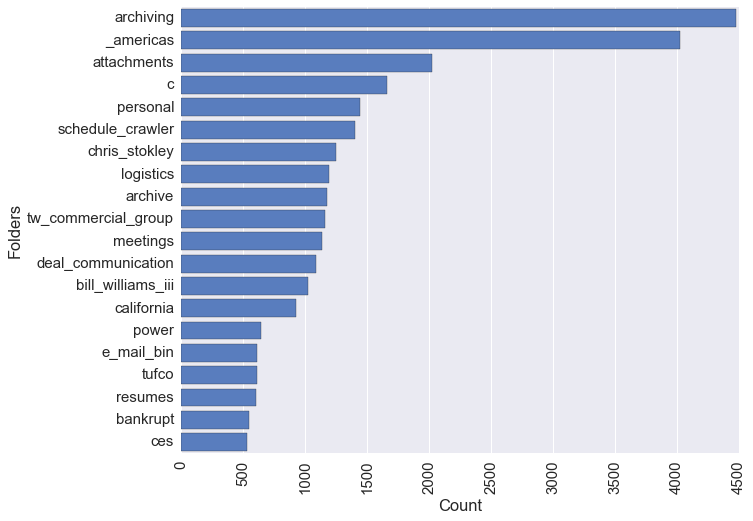

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation) 
    sns.plt.show()
    
barplot(df = count[:20], X = "folder", Y = "Folder Names", figsize = (10, 8), color = 'b', orient = 'h', ylabel = "Folders", xlabel = "Count", font_scale = 1.5, rotation = 90)

**Figure 1**: Bar plot showing 20 folders that contain the most e-mails 

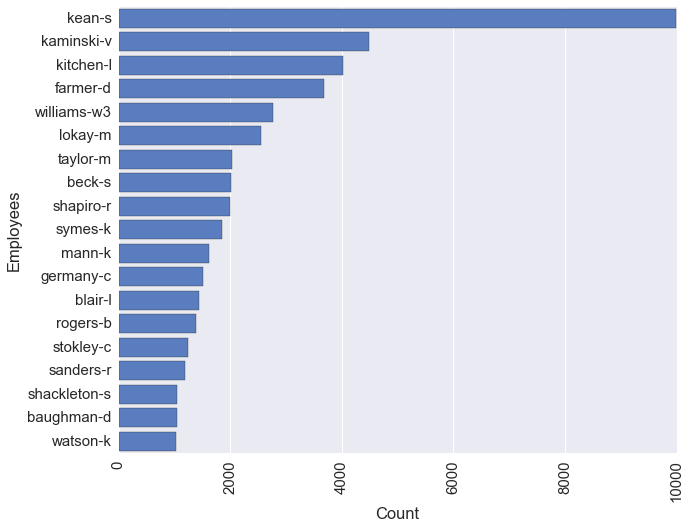

In [136]:
mail_count = emails["employee"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"employee": "Count"}, inplace = True)
count["Employees"] = indices
barplot(df = count[:30], X = "Count", Y = "Employees", figsize = (10, 8), color = 'b', orient = 'h', ylabel = "Employees", xlabel = "Count", font_scale = 1.5, rotation = 90)

**Figure 2**: Bar graph showing 30 employees who had the highest number of sent e-mails

In figure 2, we see that *kean-s, kaminski-v, kitchen-l, farmer-d, williams-w3* and *lokay-m* had over 2000 e-mails contained within topical folders.  There are a few employees, such as *taylor-m, beck-s, shapiro-r* and *symes-k* who had approximately 2000 e-mails.  The rest of employees had anywhere between 50 - 1800 emails (some not shown).  For this project, I'll use employees that had more than 1000 e-mails in topical folders.   

### Extract e-mails for employees who had over 1000 e-mails

In [6]:
email_count = dict(emails["employee"].value_counts())
reduced_emails = [key for key, val in email_count.items() if val > 1000]
emails = emails.loc[emails['employee'].isin(reduced_emails)]
print emails["employee"].value_counts()

kean-s          9990
kaminski-v      4481
kitchen-l       4026
farmer-d        3677
williams-w3     2774
lokay-m         2553
taylor-m        2030
beck-s          2008
shapiro-r       2004
symes-k         1860
mann-k          1623
germany-c       1506
blair-l         1438
rogers-b        1396
stokley-c       1252
sanders-r       1196
shackleton-s    1048
baughman-d      1044
watson-k        1034
Name: employee, dtype: int64


## 3.  Bag-of-words model

### Introducing the Bag-of-words model

For the computer to make inferences of the e-mails, it has to be able to interpret the text by making a numerical representation of it.  One way to do this is by using something called a [**Bag-of-words model**](https://en.wikipedia.org/wiki/Bag-of-words_model).  It will take the e-mails as a string and convert it into a numerical vector to show the frequency that each unique word appears over the entire dataset.  

The next step in creating a Bag-of-words model is called tokenization.  By tokenizing each e-mail, each string is split into a list of words. Scikit-learn has a `CountVectorizer` class that is able to not only tokenize documents but also implement the bag-of-words model on the data too.  It takes in a list of strings, in our case words, and outputs a dictionary mapping words as keys to their respective integer indices.  

Lastly, we apply the Term frequency-inverse document frequency ([tf-idf](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)) to downweight words that appear frequently in the e-mails but do not contain useful information.  Sci-kit learn has a transformer called the `TfidTransformer` to do this.  The `TfidTransformer` also normalizes the tf-idfs using L2-normalization.  Using L2-normalization helps to penalize the weight of the tf-dfs and prevent overfitting.  Tf-idf is an alternative approach to removing the most frequent words that will appear but have little relevance and for which little information can be gained from their inclusion.

Below are a few functions that handle all the above steps:

In [7]:
def get_messages(df):
    messages = []
    for item in df:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        # lower case messages
        message_body = message_body.lower()
        messages.append(message_body)
    return messages

#### Create bag-of-words model

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

def get_bag(cleaned_msg):
    from sklearn.feature_extraction.text import CountVectorizer
    count = CountVectorizer()
    docs = np.array(cleaned_msg)
    bag = count.fit_transform(docs)
    vocab = count.vocabulary_
    bag = bag.toarray()
    tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
    bag = tfidf.fit_transform(count.fit_transform(docs)).toarray()
    return bag

## 4. Training/test set splits

The normalized bag of feature vectors will be used to train a series of models to see how well we can classify each e-mail into folders.  The target variables/labels will be the values found in the "folder" column of the `emails` dataframe.  

When creating training and testing data, we cannot randomly shuffle the data due to the interconnected nature of e-mails.  [Conversation threading](https://en.wikipedia.org/wiki/Conversation_threading) is a perfect example of this interconnectedness.  Randomly shuffling the data would add bias to our predictions, since it is essentially equivalent to looking ahead into the future to learn about the past.  This is something we do not want to do at all.  

To work around this, we will split the data into training and testing sets in chronological order, always training on data that took place before the testing data.  The initial training set size, *N* will be set to *100*.  Test sets will be set to *20%* the size of the training set.  After each pass through the data, the size of *N* increases by *1* until *(K-1)N* splits have been made, where *K* is the number of splits.  

In [11]:
def get_folds(X, N):
    fold = {}
    K = 0
    train_size = 0
    test_size = 0
    total = 0
    while total < len(X):
        old_total = total
        train_size = N
        test_size = N * 0.2
        total = train_size + test_size
        
        if total > len (X):
            diff = len(X) - old_total
            train_size = diff * 0.8
            test_size = diff * 0.2
            fold[K] = (train_size, test_size)
            return fold
        fold[K] = (train_size, test_size)
        K += 1
        N *= 2
    return fold   

The `get_folds()` function returns a dictionary containing the train and test sizes to be used for each fold.  Each key is represents a fold with a tuple as its value, where the first element in the tuple refers to the training set size and the second element is the test size.  For example, on the first pass over the data, the training data will be split to get the first 100 samples and the test set will be split to get the first 20 samples.  Notice that the last fold will split on the remaining training and test data.

### Classifiers

* [K-Nearest Neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* Wide-Margin Winnow 

Each model will be evaluated based on a classification [accuracy score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), the fraction of correct predictions of the total number of predictions.  

In [125]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Empty dictionary used to store the mean test scores
accuracy_scores = {}

def train_test_split(X, y, clf, key, folds):
    test_scores = []
    train_scores = []
    
    for k, split_sizes in folds.items(): 
        training_size = int(split_sizes[0])
        test_size = int(split_sizes[1])
        # split data into training and testing sets
        X_train = X[:training_size]
        y_train = y[:training_size]
        X_test = X[:test_size]
        y_test = y[:test_size]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        # test scores
        score = (accuracy_score(y_true = y_test, y_pred = y_test_pred, normalize = True))
        test_scores.append(score)
        # train scores
        score = (accuracy_score(y_true = y_train, y_pred = y_train_pred, normalize = True))
        train_scores.append(score)
    
    mean_test_score = np.mean(test_scores)
    # save the avg score 
    insert_value(accuracy_scores, key, mean_test_score)
    print mean_test_score
    print "test score: {} \n".format(mean_test_score)
    print "train score: {} \n".format(np.mean(train_scores))

In [ ]:
employee_list = dict(emails["employee"].value_counts()).keys()
performance = pd.DataFrame(employee_list, columns = ["employees"])
knn = KNeighborsClassifier(n_neighbors=3)

nb = MultinomialNB()
classifiers = {"knn":knn, "tree":tree_clf, "naives_bayes":nb}

for i, employee in enumerate(employee_list):
    employee_data = emails[emails["employee"] == employee]
    messages = get_messages(employee_data["message"])
    cleaned_messages = remove_reg_expressions(messages)
    bag = get_bag(cleaned_messages)
    X = bag
    y = employee_data["folder"]
    folds = get_folds(X, N = 100)
    for key, clf in classifiers.items():
        train_test_split(X, y, clf, key, folds)

for key, val in accuracy_scores.items():
    performance[key] = val
#performance.to_csv(path_or_buf = "performance/performance.csv", sep=',', encoding='utf-8')

### Results

In the code above, we trained, tested and split the data for each employee by using the employee's e-mails as training data and the respective folders as targets.  The message body for each e-mail was extracted, cleaned and converted into a numerical representation using the bag-of-words model.  Once the bag was preprocessed, it was fitted to a KNN and Multinomial Naive Bayes classifers and predictions were made over several passes of size K, which was different for each employee and varied depending on the number of e-mails per employee.  

Training and testing took quite some time due the number of passes over the data, the size of the dataset.  For this reason, the results were stored in a csv file for reference.  Here are the loaded results: